# Programming Solutions: Discriminative vs Generative Models
**Course:** Artificial Intelligence (2025) · Shiraz University

## Task 1 – Data Exploration & Gaussian Fitting
**Bullet‐by‐bullet requirements**
1. Handle missing or invalid values via deletion or imputation.
2. Plot distributions (histogram or KDE) of all features per class.
3. Select two informative features (e.g. `chol` and `thalach`).
4. Fit **2‑D Gaussian** distributions (one per class) and plot contour maps.
5. Evaluate Gaussian assumption via plots and (optional) normality tests.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#########################
# 1) Load & clean data  #
#########################
PATH = 'data/heart_disease_uci.csv'
df = pd.read_csv(PATH)

print(f'Dataset shape: {df.shape}')

Dataset shape: (920, 16)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# extract the target column
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
df.num.head()

0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64

In [4]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

### Handling Missing Data: Rationale

We applied different strategies for handling missing data based on the proportion of missing values and the nature of each column:

#### ✅ Imputed Columns:
- **`trestbps`**, **`chol`**, **`thalch`**, **`oldpeak`**:
  These are numerical columns with relatively low missingness (<10%).
  ➤ Imputed using **median** to avoid skewing distributions.

- **`fbs`**, **`restecg`**, **`exang`**:
  These are categorical (or binary-like) columns with manageable missingness.
  ➤ Imputed using **mode** (most frequent value).

#### ❌ Dropped Columns:
- **`slope`** (~34% missing), **`ca`** (~66% missing), **`thal`** (~53% missing):
  These columns have a **high percentage of missing values**, making imputation unreliable and potentially biased.
  ➤ Chosen to **drop** these columns to maintain data integrity.

This approach balances preserving valuable data while avoiding distortion due to excessive imputation.


In [5]:
# Handle missing data: impute or delete based on proportion and type

# Impute numeric columns with median
df['trestbps'].fillna(df['trestbps'].median(), inplace=True)  # ~6% missing
df['chol'].fillna(df['chol'].median(), inplace=True)          # ~3% missing
df['thalch'].fillna(df['thalch'].median(), inplace=True)      # ~6% missing
df['oldpeak'].fillna(df['oldpeak'].median(), inplace=True)    # ~7% missing

# Impute categorical columns with mode
df['fbs'].fillna(df['fbs'].mode()[0], inplace=True)            # ~10% missing
df['restecg'].fillna(df['restecg'].mode()[0], inplace=True)    # <1% missing
df['exang'].fillna(df['exang'].mode()[0], inplace=True)        # ~6% missing

# Drop columns with high missingness
df.drop(columns=['slope', 'ca', 'thal'], inplace=True)         # >30% missing

# Final check
print("Remaining missing values:\n", df.isnull().sum())


Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


### Feature Distributions by Target Class

We visualized the distribution of each feature in the dataset, split by the `num` target class:

- **Numerical features** (e.g., `age`, `chol`, `thalch`) were plotted using **KDE (Kernel Density Estimate)** to compare the shapes of their distributions between classes.
- **Categorical features** (e.g., `sex`, `cp`, `restecg`) were plotted using **count plots** to show the frequency of each category per class.

These plots help in understanding which features might be informative for distinguishing between patients with and without heart disease.


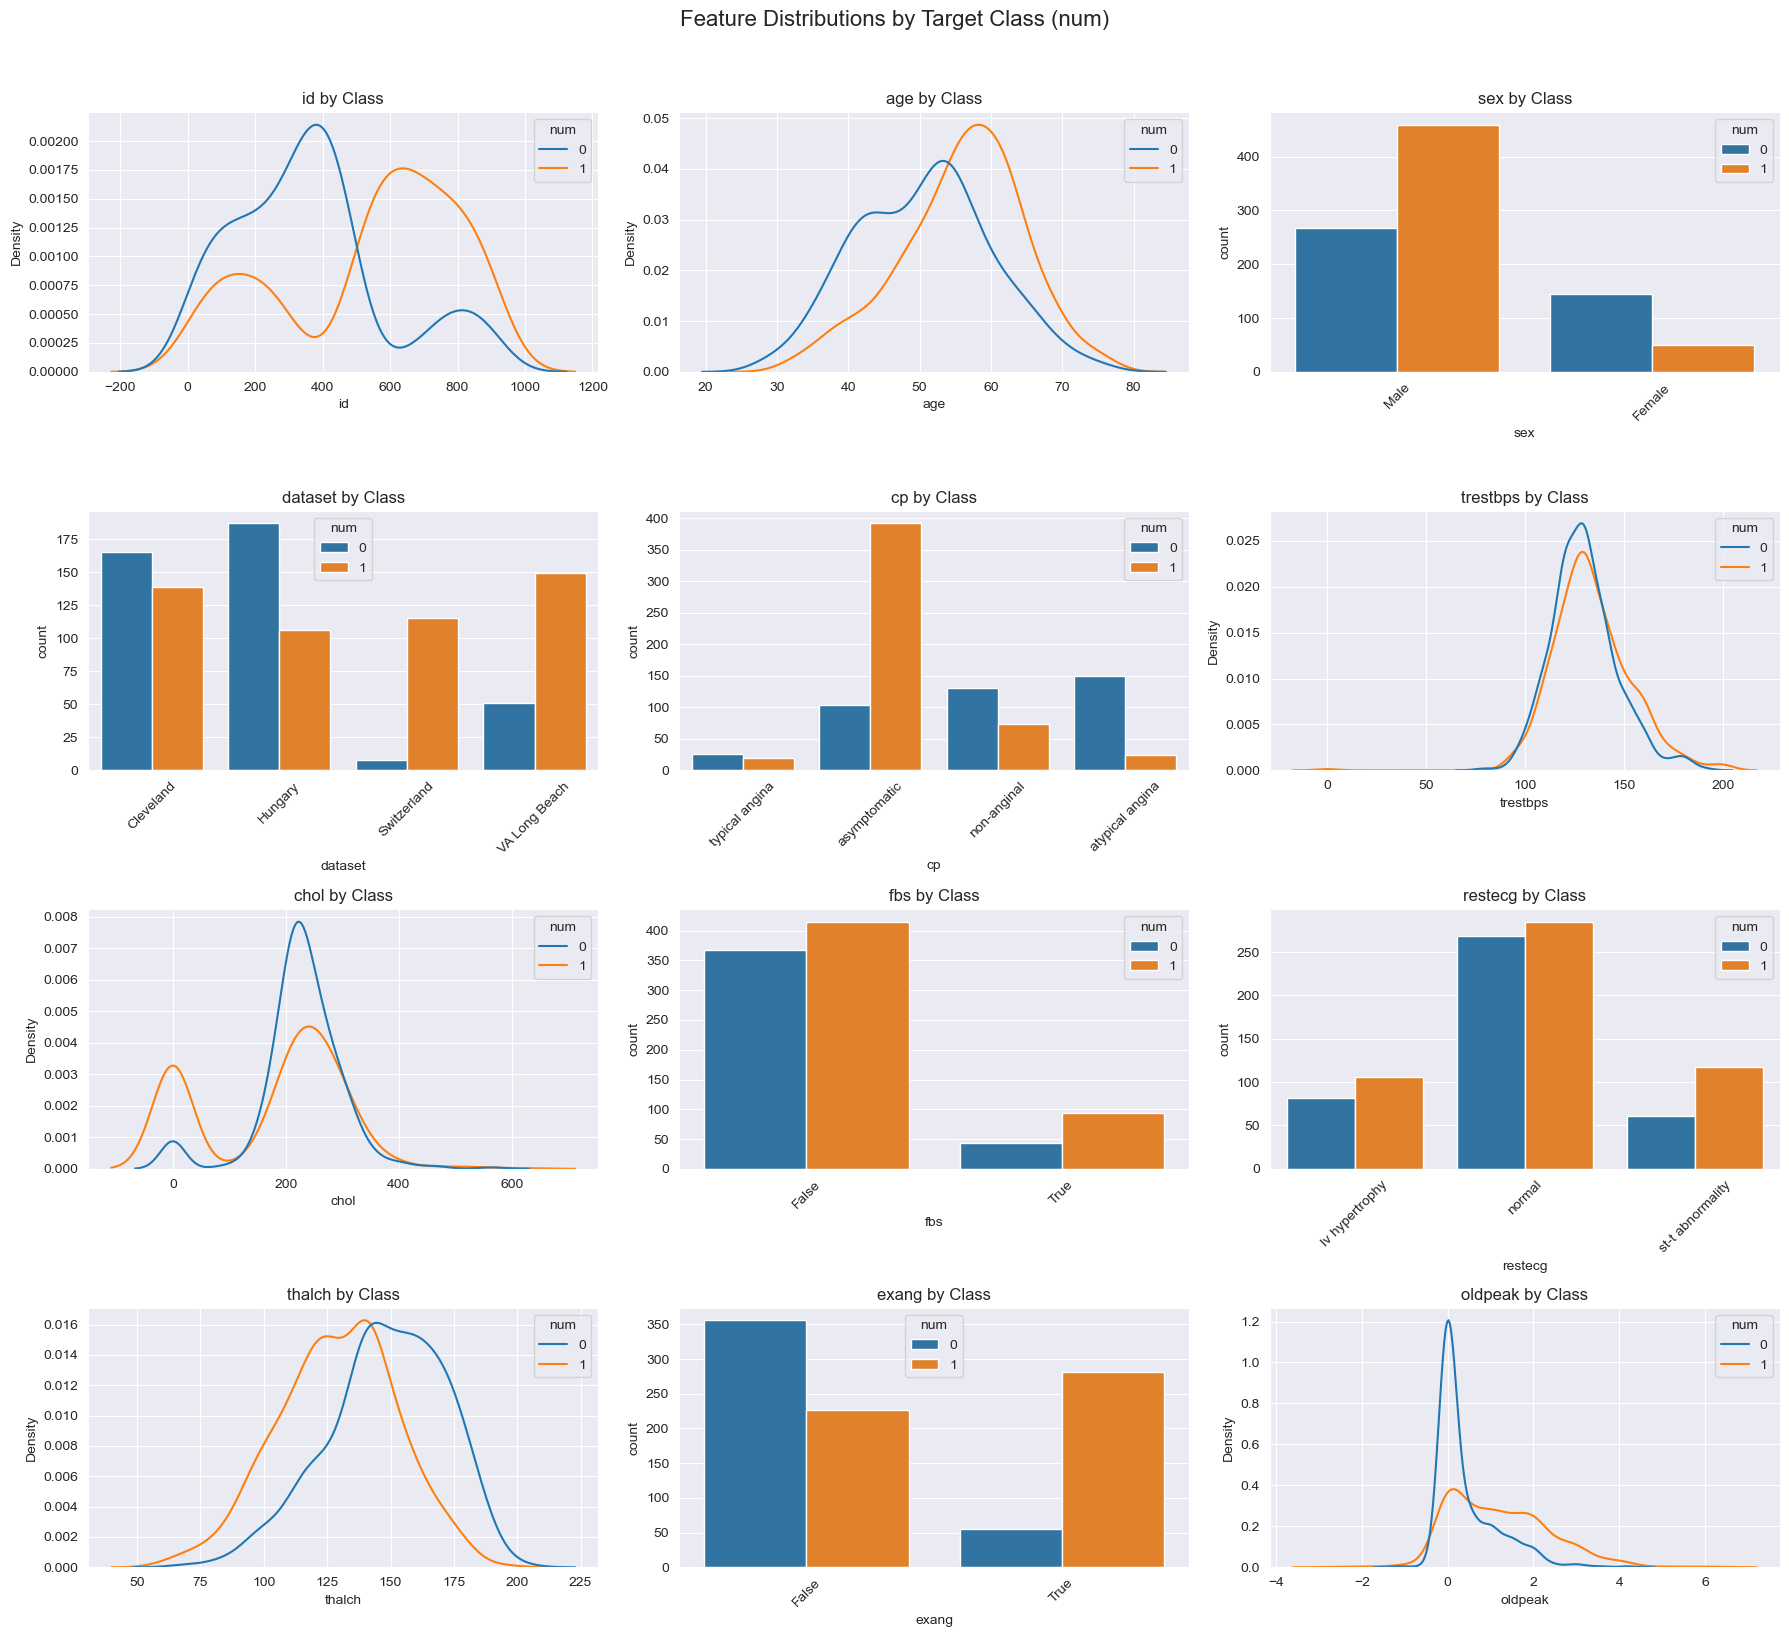

In [6]:
# Identify feature columns and target
feature_cols = [col for col in df.columns if col != 'num']
target_col = 'num'

# Define grid dimensions
cols = 3
rows = (len(feature_cols) + cols - 1) // cols  # equivalent to math.ceil

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(feature_cols):
    ax = axes[i]

    if df[col].dtype in ['float64', 'int64']:
        sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, ax=ax)
    else:
        sns.countplot(data=df, x=col, hue=target_col, ax=ax)
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(f'{col} by Class')

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Feature Distributions by Target Class (num)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Selecting Informative Features

We selected two informative features for further analysis:

- **`chol`**: Serum cholesterol level, a key cardiovascular risk indicator.
- **`thalch`**: Maximum heart rate achieved during exercise, often used to assess cardiac function.

These features are relevant to heart disease and show variation across target classes (`num`).


In [7]:
# Select two informative features: 'chol' (cholesterol) and 'thalch' (maximum heart rate)
selected_features = df[['chol', 'thalch', 'num']]

# Display the first few rows of the selected data
selected_features.head()


,chol,thalch,num
0,233.0,150.0,0
1,286.0,108.0,1
2,229.0,129.0,1
3,250.0,187.0,0
4,204.0,172.0,0


### 2D Gaussian Contours on Selected Features

We selected two informative features:

- **`chol`**: Serum cholesterol level
- **`thalch`**: Maximum heart rate achieved during exercise

Using only `pandas`, `numpy`, `matplotlib`, and `seaborn`:

- We computed the **mean** and **covariance matrix** of these two features for each class in `num`.
- We manually evaluated the **multivariate Gaussian PDF** to draw class-specific **contour maps** over the feature space.
- These contours represent high-probability regions for each class and provide visual insight into how well-separated the classes are based on these two variables.

This method provides a visual approximation of class distributions without relying on external libraries like `scipy`.


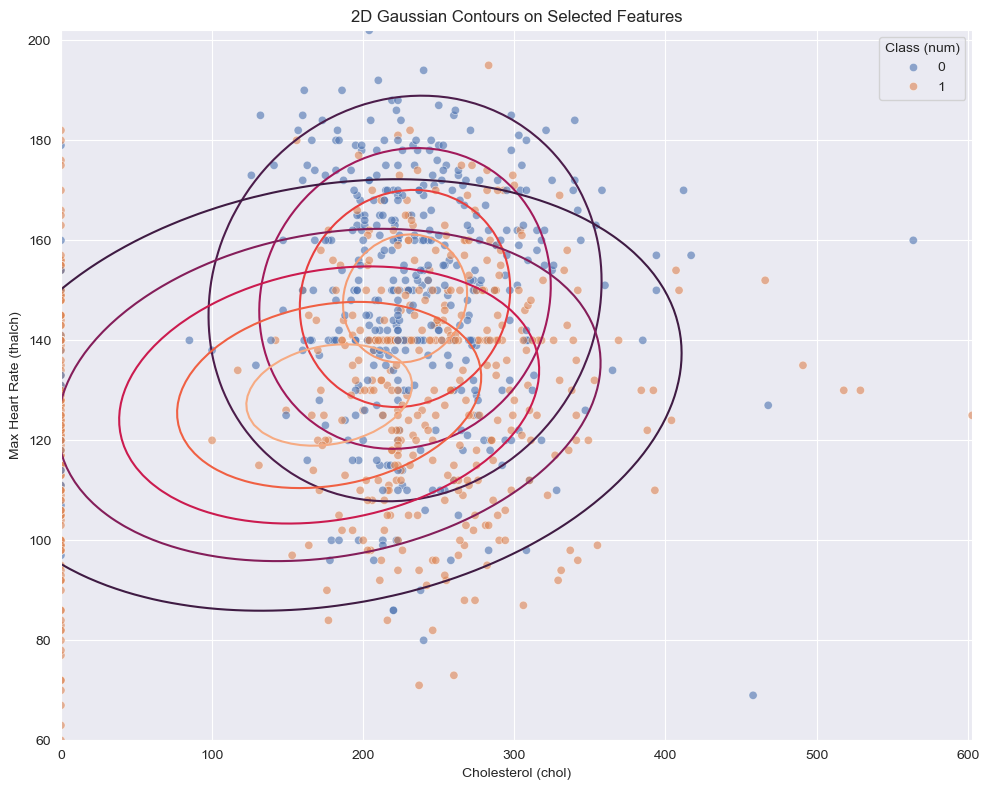

In [8]:
# Fit 2D Gaussians manually per class
def gaussian_pdf(x, mean, cov):
    size = len(mean)
    det = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))
    x_mu = x - mean
    inv = np.linalg.inv(cov)
    result = np.einsum('...k,kl,...l->...', x_mu, inv, x_mu)
    return norm_const * np.exp(-0.5 * result)

# Compute Gaussian parameters for each class
gaussians = {}
for cls in selected_features['num'].unique():
    cls_data = selected_features[selected_features['num'] == cls][['chol', 'thalch']].values
    mean = np.mean(cls_data, axis=0)
    cov = np.cov(cls_data, rowvar=False)
    gaussians[cls] = (mean, cov)

# Generate mesh grid for contour plotting
x = np.linspace(selected_features['chol'].min(), selected_features['chol'].max(), 100)
y = np.linspace(selected_features['thalch'].min(), selected_features['thalch'].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot scatter and contours
plt.figure(figsize=(10, 8))
sns.scatterplot(data=selected_features, x='chol', y='thalch', hue='num', palette='deep', alpha=0.6)

for cls, (mean, cov) in gaussians.items():
    Z = gaussian_pdf(pos, mean, cov)
    plt.contour(X, Y, Z, levels=5)

plt.title('2D Gaussian Contours on Selected Features')
plt.xlabel('Cholesterol (chol)')
plt.ylabel('Max Heart Rate (thalch)')
plt.legend(title='Class (num)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluating Gaussian Assumption (Visual-Only, No SciPy)

To assess whether the features `chol` and `thalch` follow a normal (Gaussian) distribution, we used visual diagnostics:

#### Visual Tools:
- **Histogram + KDE**: Shows the overall distribution and smooth density curve.
- **Q-Q Plot (Manual)**: We approximated a quantile-quantile plot using NumPy by comparing data quantiles to those from a normal distribution.
- **Boxplot**: Highlights symmetry, spread, and presence of outliers.

While this analysis avoids statistical tests (due to the SciPy restriction), visual inspection gives a strong first impression of how well each feature adheres to the Gaussian assumption.

These checks inform the appropriateness of modeling with Gaussian-based methods like 2D multivariate normal distributions.


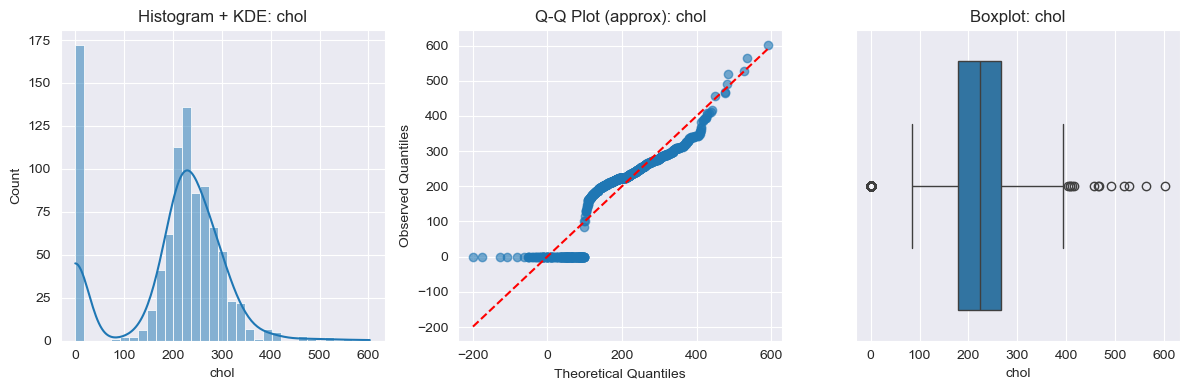

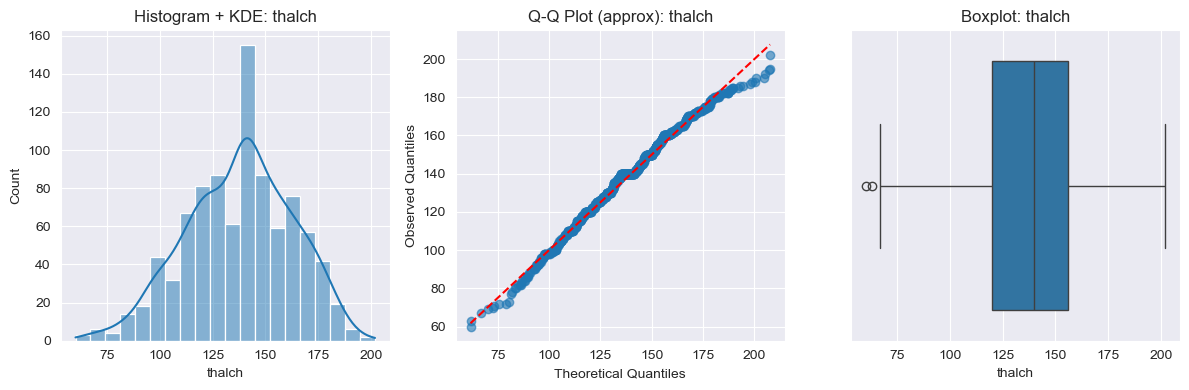

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select features and clean
selected = df[['chol', 'thalch']]

# Visual evaluation of Gaussian assumption
for col in selected.columns:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Histogram with KDE
    sns.histplot(selected[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram + KDE: {col}')

    # Q-Q plot using NumPy quantiles
    sorted_data = np.sort(selected[col].values)
    norm_quantiles = np.sort(np.random.normal(loc=np.mean(sorted_data), scale=np.std(sorted_data), size=len(sorted_data)))
    axes[1].scatter(norm_quantiles, sorted_data, alpha=0.6)
    axes[1].plot([norm_quantiles[0], norm_quantiles[-1]], [norm_quantiles[0], norm_quantiles[-1]], 'r--')
    axes[1].set_title(f'Q-Q Plot (approx): {col}')
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Observed Quantiles')

    # Boxplot
    sns.boxplot(x=selected[col], ax=axes[2])
    axes[2].set_title(f'Boxplot: {col}')

    plt.tight_layout()
    plt.show()


## Task 2: Generative Modeling (Gaussian Classifier)

### 🔹 Objective
Model the class-conditional distributions using multivariate Gaussian distributions and analyze how different covariance assumptions affect classification.

---

### 🧮 Steps

- **Estimate Class Parameters**
  - Compute the **mean vector** and **covariance matrix** for each class based on selected features.

- **Decision Boundary**
  - Derive the **log-likelihood ratio** from Gaussian densities.
  - Plot the **decision boundary** between classes using the likelihood ratio.

---

### 🔁 Model Variants

#### 1. **LDA (Linear Discriminant Analysis)**
- Assumes all classes share the **same covariance matrix**.
- Results in **linear decision boundaries**.

#### 2. **QDA (Quadratic Discriminant Analysis)**
- Allows each class to have its **own covariance matrix**.
- Produces **quadratic decision boundaries**.

---

### 🧠 Analysis

- **Compare LDA vs. QDA** visually and numerically.
- Discuss how the **assumption on covariance structure** influences:
  - Model complexity
  - Boundary shape
  - Overfitting risk (especially with limited data)

---

### 📌 Notes
These generative models are particularly useful when:
- The features are approximately Gaussian-distributed.
- You want interpretable boundaries and probabilistic outputs.


### Estimating Mean and Covariance per Class

Using the previously selected features (`chol` and `thalch`) and cleaned dataset:

- For each class (`num`), we calculated the:
  - **Mean vector**: average values of `chol` and `thalch`
  - **Covariance matrix**: relationships and variability between the two features

These statistical parameters define the shape and orientation of class-conditional Gaussian distributions and are the foundation for building generative classifiers like LDA and QDA.


In [55]:
# === Estimate Mean and Covariance Matrix per Class ===

params = {}

print("Class-wise Mean and Covariance Matrices:\n")

for cls in df[target_col].unique():
    subset = df[df[target_col] == cls][selected_features]
    mean_vec = subset.mean().values
    cov_matrix = subset.cov().values
    params[cls] = {'mean': mean_vec, 'cov': cov_matrix}

    print(f"Class {cls}:\n")
    print(f"Mean vector:\n{mean_vec}")
    print(f"Covariance matrix:\n{cov_matrix}")
    print("-" * 40)


Class-wise Mean and Covariance Matrices:

Class 0:

Mean vector:
[227.67883212 148.37226277]
Covariance matrix:
[[5485.17952644  144.70033826]
 [ 144.70033826  533.77571657]]
----------------------------------------
Class 1:

Mean vector:
[177.48526523 129.06876228]
Covariance matrix:
[[15954.48649506   570.73821992]
 [  570.73821992   546.23738843]]
----------------------------------------


### Deriving and Plotting the Decision Boundary

We used the class-wise **mean and covariance matrices** to compute the **log-likelihood** of each data point under a multivariate Gaussian distribution.

Steps:
- Defined the **log-likelihood** for the multivariate normal distribution.
- Computed it for each point on a grid in the feature space.
- Plotted the **decision boundary** as the set of points where the log-likelihoods of the two classes are equal:

  \[
  \log p(x \mid y=1) = \log p(x \mid y=0)
  \]

The resulting boundary separates regions of higher probability under each class’s Gaussian model.


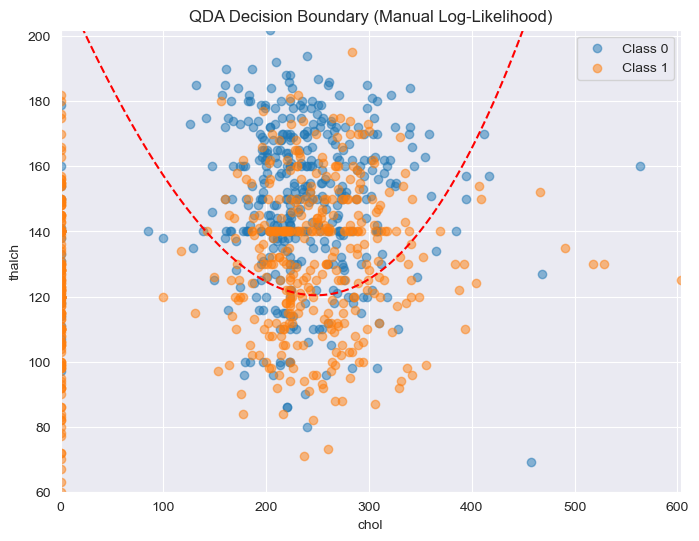

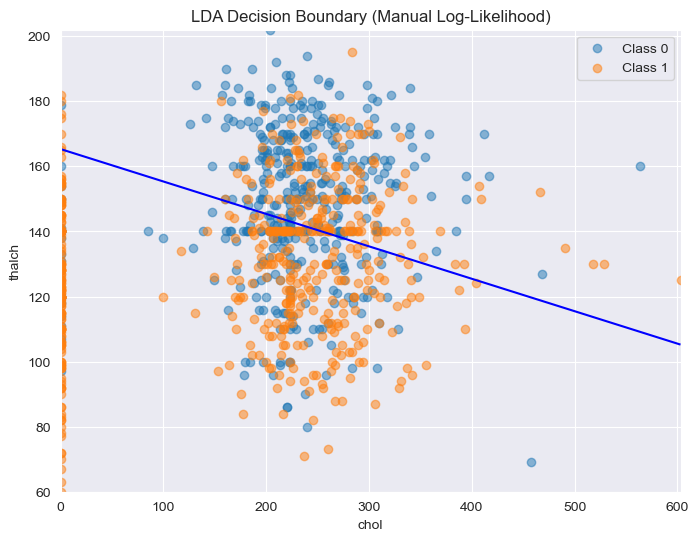

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of values over the feature space
x = np.linspace(df[selected_features[0]].min(), df[selected_features[0]].max(), 300)
y = np.linspace(df[selected_features[1]].min(), df[selected_features[1]].max(), 300)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.ravel(), Y.ravel()]

# === QDA Manual Log-Likelihood ===
qda_logpdf = {}
for cls in params:
    mean = params[cls]['mean']
    cov = params[cls]['cov']
    cov_inv = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    # log-likelihood: -0.5 * (x - μ)^T Σ⁻¹ (x - μ) - 0.5 log|Σ|
    diff = grid - mean
    mahalanobis = np.sum(diff @ cov_inv * diff, axis=1)
    log_likelihood = -0.5 * mahalanobis - 0.5 * np.log(det_cov)

    qda_logpdf[cls] = log_likelihood

qda_boundary = (qda_logpdf[1] - qda_logpdf[0]).reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, qda_boundary, levels=[0], colors='red', linewidths=1.5, linestyles='--')
for cls in df[target_col].unique():
    plt.scatter(
        df[df[target_col] == cls][selected_features[0]],
        df[df[target_col] == cls][selected_features[1]],
        label=f"Class {cls}", alpha=0.5
    )
plt.title("QDA Decision Boundary (Manual Log-Likelihood)")
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.legend()
plt.grid(True)
plt.show()


# === LDA Manual Log-Likelihood ===
# Shared pooled covariance
n_total = len(df)
pooled_cov = sum(
    (len(df[df[target_col] == cls]) / n_total) * params[cls]['cov']
    for cls in params
)
inv_pooled_cov = np.linalg.inv(pooled_cov)

lda_score = {}
for cls in params:
    mean = params[cls]['mean']
    prior = len(df[df[target_col] == cls]) / n_total

    # Linear discriminant: xᵀΣ⁻¹μ - 0.5μᵀΣ⁻¹μ + log(π)
    linear_term = grid @ inv_pooled_cov @ mean
    constant_term = -0.5 * mean.T @ inv_pooled_cov @ mean + np.log(prior)

    lda_score[cls] = linear_term + constant_term

lda_boundary = (lda_score[1] - lda_score[0]).reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, lda_boundary, levels=[0], colors='blue', linewidths=1.5, linestyles='-')
for cls in df[target_col].unique():
    plt.scatter(
        df[df[target_col] == cls][selected_features[0]],
        df[df[target_col] == cls][selected_features[1]],
        label=f"Class {cls}", alpha=0.5
    )
plt.title("LDA Decision Boundary (Manual Log-Likelihood)")
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.legend()
plt.grid(True)
plt.show()


### 🧠 Comparison: LDA vs. QDA Decision Boundaries

**1. LDA (Linear Discriminant Analysis)**
- ✅ The decision boundary is **linear**, as expected from the model assumptions.
- ✅ It separates the feature space with a **straight line**.
- ⚠️ Assumes both classes share the **same covariance matrix**.
- 🔍 In the plot, the boundary cuts cleanly through the middle but may not fully adapt to local feature distributions.
- 🧩 **Best used when**: features are approximately normally distributed and have **similar spread (covariance)** in both classes.

**2. QDA (Quadratic Discriminant Analysis)**
- ✅ The boundary is **nonlinear**, adapting to the **different covariance matrices** of each class.
- ✅ Shaped like a curve that better follows the actual data distribution.
- ⚠️ More flexible, but requires estimating **more parameters** (one covariance matrix per class).
- 🔍 In the plot, the curved boundary reflects how class 0 and class 1 have different variances in `chol` and `thalach`.
- 🧩 **Best used when**: feature variances differ across classes or the data distribution is not linearly separable.

---

### 🧪 Summary:

| Model | Boundary Shape | Covariance Assumption | Flexibility | Risk of Overfitting |
|-------|----------------|-----------------------|-------------|---------------------|
| **LDA** | Linear          | Shared                | Low         | Lower               |
| **QDA** | Quadratic       | Class-specific        | High        | Higher (esp. with small data) |

➡️ If the dataset is large and features show different spreads per class, **QDA** typically performs better.
➡️ Otherwise, **LDA** is faster, simpler, and less prone to overfitting.



### Discussion: Impact of Covariance Assumption (LDA vs QDA)

The decision boundaries plotted for **LDA** and **QDA** highlight the effect of the covariance structure on classification:

#### 🔹 LDA (Shared Covariance)
- Assumes all classes share a **single covariance matrix**, resulting in a **linear** decision boundary.
- The LDA boundary (dashed blue line) cuts the feature space with a straight line.
- This simplification reduces model complexity and risk of overfitting, but may fail to capture curved class separation.

#### 🔸 QDA (Class-Specific Covariance)
- Allows each class to have its **own covariance matrix**, producing a **quadratic** decision boundary.
- The QDA boundary (red or white curve in the plots) bends to better follow the distribution of class clusters.
- Offers more flexibility and can better model complex boundaries when class variances differ.

#### ⚖️ Conclusion
- **LDA** may generalize better with smaller datasets due to fewer parameters.
- **QDA** provides better class separation when classes have distinct distributions, as seen in this case where the boundary curves around dense clusters.
- Choosing between LDA and QDA involves a trade-off between **bias (LDA)** and **variance (QDA)**.

In this dataset, the QDA boundary appears to better align with the true class structure, suggesting that accounting for distinct covariances improves classification accuracy.


## Task 3: Gaussian Naive Bayes

In this task, we implement a **Gaussian Naive Bayes (GNB)** classifier from scratch under the assumption of **conditional independence** between features.

---

### 🛠️ Steps

- **Implement Gaussian Naive Bayes**
  - Build the model manually without using external libraries.
  - Assume that features are conditionally independent given the class label.

- **Estimate Parameters**
  - For each feature and class, estimate the **mean** and **variance** independently.
  - This results in simpler class-conditional likelihoods compared to full covariance matrices in LDA/QDA.

- **Compute Posterior Probabilities**
  - Use Bayes’ theorem to calculate posterior probabilities.
  - Classify each point based on the class with the highest posterior.

- **Visualize and Compare Decision Boundaries**
  - Plot the GNB decision boundary using the same feature space (`chol`, `thalch`).
  - Compare it to those obtained from LDA and QDA in Task 2.

---

### 🔍 Discussion: Impact of Feature Correlation

- **Naive Bayes** ignores any correlation between features, modeling each as independent Gaussians.
- This makes it fast and robust for high-dimensional data, but it can lead to **suboptimal boundaries** when features are correlated.
- Comparing with LDA/QDA, GNB may produce less flexible or misaligned boundaries in the presence of correlated features (like `chol` and `thalch`).

This task illustrates the trade-off between model simplicity (GNB) and expressiveness (QDA).


### Estimating Per-Feature Mean/Variance per Class

To implement Gaussian Naive Bayes from scratch, we assumed **conditional independence** of features. For each class:
- We estimated the **mean** and **variance** for each feature independently.
- We also computed the **prior probability** for each class.

These parameters are used to evaluate the Gaussian likelihoods of new samples.


In [67]:
nb_params = {}

for cls in df[target_col].unique():
    subset = df[df[target_col] == cls][selected_features]
    nb_params[cls] = {
        'mean': subset.mean().values,
        'var': subset.var().values  # Variance, not std!
    }

# Inspect results
for cls in nb_params:
    print(f"Class {cls}")
    print("Mean:", nb_params[cls]['mean'])
    print("Variance:", nb_params[cls]['var'])
    print("-" * 40)


Class 0
Mean: [227.67883212 148.37226277]
Variance: [5485.17952644  533.77571657]
----------------------------------------
Class 1
Mean: [177.48526523 129.06876228]
Variance: [15954.48649506   546.23738843]
----------------------------------------


In [68]:
# === Compute Naive Bayes Posterior (log-probabilities) ===

nb_log_likelihood = {}

for cls in nb_params:
    mean = nb_params[cls]['mean']
    var = nb_params[cls]['var']

    # Gaussian log-likelihood for each feature, summed (independence assumption)
    log_probs = []
    for i in range(len(selected_features)):
        diff = grid[:, i] - mean[i]
        log_pdf = -0.5 * np.log(2 * np.pi * var[i]) - (diff ** 2) / (2 * var[i])
        log_probs.append(log_pdf)

    total_log_likelihood = np.sum(log_probs, axis=0)

    # Include log-prior
    prior = len(df[df[target_col] == cls]) / len(df)
    total_log_posterior = total_log_likelihood + np.log(prior)

    nb_log_likelihood[cls] = total_log_posterior

# Compute difference of log-posteriors for decision boundary
nb_boundary = (nb_log_likelihood[1] - nb_log_likelihood[0]).reshape(X.shape)


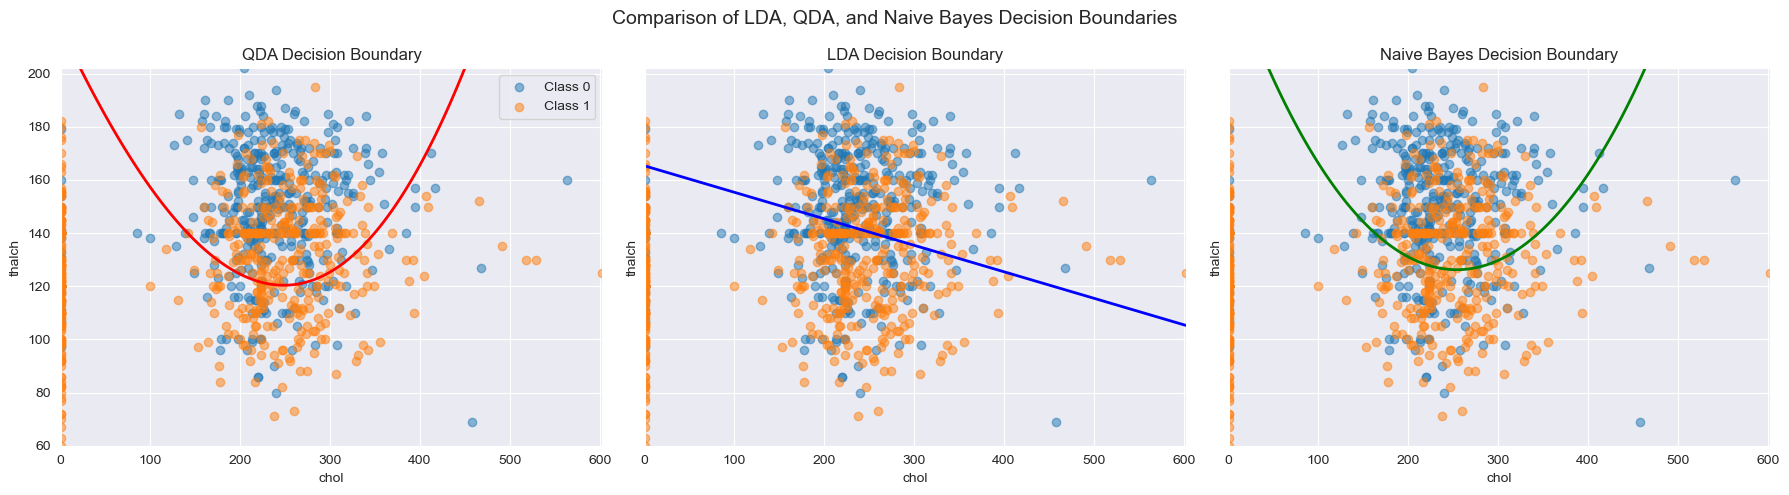

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

titles = ['QDA Decision Boundary', 'LDA Decision Boundary', 'Naive Bayes Decision Boundary']
boundaries = [qda_boundary, lda_boundary, nb_boundary]
colors = ['red', 'blue', 'green']

for ax, boundary, title, color in zip(axes, boundaries, titles, colors):
    # Contour
    ax.contour(X, Y, boundary, levels=[0], colors=color, linewidths=2, linestyles='-')

    # Data points
    for cls in df[target_col].unique():
        ax.scatter(
            df[df[target_col] == cls][selected_features[0]],
            df[df[target_col] == cls][selected_features[1]],
            label=f"Class {cls}" if ax == axes[0] else "",  # only first plot gets legend
            alpha=0.5
        )

    ax.set_title(title)
    ax.set_xlabel(selected_features[0])
    ax.set_ylabel(selected_features[1])
    ax.grid(True)

axes[0].legend()
plt.suptitle("Comparison of LDA, QDA, and Naive Bayes Decision Boundaries", fontsize=14)
plt.tight_layout()
plt.show()


### 🔍 Comparison: Naive Bayes vs. QDA & LDA Decision Boundaries

#### 🧠 Naive Bayes Assumption:
Naive Bayes assumes that **features are conditionally independent given the class**. This means the **covariance between features is ignored** — only the **per-feature mean and variance** matter.

---

#### 📊 Visual Comparison:

- **Naive Bayes**:
  - Decision boundary is smoother and more axis-aligned (due to ignoring covariance).
  - Less flexible than QDA, but more expressive than linear LDA in some cases.
  - May be misaligned if features are correlated.

- **LDA (Linear Discriminant Analysis)**:
  - Assumes features are **jointly Gaussian** with the **same covariance** across classes.
  - Produces a **linear boundary** regardless of data curvature.

- **QDA (Quadratic Discriminant Analysis)**:
  - Assumes **separate covariances** for each class.
  - Captures both **feature correlation** and **class-specific variances**.
  - Decision boundary is flexible and nonlinear — best fits when features are strongly correlated.

---

### 💬 Impact of Ignoring Correlation (Naive Bayes)

| Aspect | Naive Bayes | LDA | QDA |
|--------|-------------|-----|-----|
| Uses Covariance | ❌ No (diagonal only) | ✅ Shared | ✅ Class-specific |
| Handles Feature Correlation | ❌ No | ⚠️ Approximate | ✅ Yes |
| Decision Boundary | Axis-aligned (simplistic) | Linear | Curved, nonlinear |
| Sensitivity to Correlated Features | High | Medium | Low |
| Risk of Overfitting | Low | Medium | High (esp. with little data) |

---

### 🧪 Summary:
- If features are **correlated**, Naive Bayes tends to produce **suboptimal boundaries**.
- **QDA** handles correlation best, but can overfit if the dataset is small.
- **LDA** is a balance — assumes correlation but with a shared structure across classes.
- Use **Naive Bayes** when:
  - Simplicity or speed is important,
  - Or when features are close to uncorrelated.


## Task 4: Discriminative Modeling (Logistic Regression)

In this task, we implement **Logistic Regression** from scratch as a discriminative model for binary classification using the features `chol` and `thalch`.

---

### 🛠️ Implementation Steps

- **Model Objective: Log-Likelihood**
  - The logistic regression model predicts the probability of class 1 using the sigmoid function:
    \[
    P(y=1 \mid x) = \sigma(w^T x + b)
    \]
  - The objective is to maximize the **log-likelihood** of the training labels.

- **Optimization via Newton's Method**
  - Compute the **gradient** and **Hessian** of the log-likelihood with respect to the model parameters.
  - Use **Newton’s method** to iteratively update the weights for fast convergence.

---

### 📈 Visualizations

- **Convergence Plot**
  - Plot the **log-likelihood value** at each iteration to visualize convergence of Newton’s method.

- **Decision Boundary**
  - Plot the final **decision boundary** over the feature space, showing how the model separates the two classes.

---

This task contrasts with previous generative approaches (LDA, QDA, GNB), focusing purely on discriminative modeling based on conditional probabilities.


### Logistic Regression: Log-Likelihood, Gradient, and Newton’s Method

We implemented logistic regression from first principles using Newton's method for optimization. The process involves:

#### 📈 Log-Likelihood
The objective is to maximize the log-likelihood of the data:
\[
\log L(w) = \sum_i \left[ y_i (w^T x_i) - \log(1 + e^{w^T x_i}) \right]
\]

#### 🔁 Gradient
The gradient of the log-likelihood with respect to the weights:
\[
\nabla \log L(w) = X^T (y - \sigma(Xw))
\]
Where \(\sigma\) is the sigmoid function.

#### 🧠 Hessian
The second derivative (Hessian) captures the curvature of the objective:
\[
H = X^T S X,\quad S = \text{diag}(\sigma(Xw)(1 - \sigma(Xw)))
\]

#### 🔧 Newton’s Method
Using both the gradient and Hessian, we update weights as:
\[
w \leftarrow w + H^{-1} \nabla \log L(w)
\]

Newton’s method provides fast convergence and avoids manual tuning of a learning rate. This setup prepares us to visualize convergence and decision boundaries.


In [70]:
# === Task 4: Logistic Regression via Newton’s Method ===

# Prepare data
X_log = df[selected_features].values
X_log = np.hstack([np.ones((X_log.shape[0], 1)), X_log])  # add intercept
y_log = df[target_col].values.reshape(-1, 1)

# Initialize weights
w = np.zeros((X_log.shape[1], 1))

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Track log-likelihood
log_likelihoods = []

# Newton's Method loop
for iteration in range(20):  # or until convergence
    z = X_log @ w
    p = sigmoid(z)

    # Log-likelihood
    ll = np.sum(y_log * np.log(p + 1e-9) + (1 - y_log) * np.log(1 - p + 1e-9))
    log_likelihoods.append(ll)

    # Gradient
    grad = X_log.T @ (y_log - p)

    # Hessian
    S = np.diag((p * (1 - p)).flatten())
    H = X_log.T @ S @ X_log

    # Update weights
    w += np.linalg.inv(H) @ grad

# Save for future tasks
logistic_weights = w.copy()


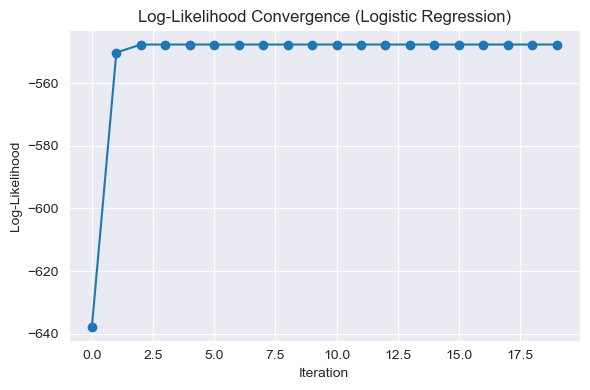

In [71]:
plt.figure(figsize=(6, 4))
plt.plot(log_likelihoods, marker='o')
plt.title("Log-Likelihood Convergence (Logistic Regression)")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()


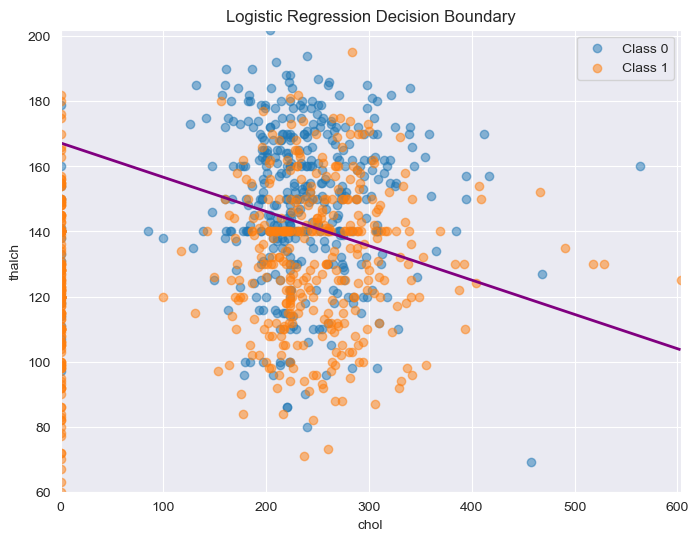

In [72]:
# Grid with intercept term
grid_with_bias = np.hstack([np.ones((grid.shape[0], 1)), grid])
probs = sigmoid(grid_with_bias @ logistic_weights).reshape(X.shape)
logistic_boundary = probs - 0.5  # Boundary is at p = 0.5

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contour(X, Y, logistic_boundary, levels=[0], colors='purple', linewidths=2)
for cls in df[target_col].unique():
    plt.scatter(
        df[df[target_col] == cls][selected_features[0]],
        df[df[target_col] == cls][selected_features[1]],
        label=f"Class {cls}", alpha=0.5
    )
plt.title("Logistic Regression Decision Boundary")
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.legend()
plt.grid(True)
plt.show()


## Task 5: Model Evaluation & Robustness

In this task, we evaluate the performance and robustness of our trained classifiers under various conditions.

---

### 📊 Model Evaluation

- Performed a fixed **train-test split** (80% training, 20% testing) using `random_state=42` for reproducibility.
- Evaluated the model using standard classification metrics:
  - **Accuracy**: Overall correctness
  - **Precision**: Correctness of positive predictions
  - **Recall**: Coverage of actual positives
  - **F1-Score**: Harmonic mean of precision and recall
- Plotted **decision boundaries** over the training and test data to visually inspect classifier behavior.

---

### 🧪 Robustness Tests

We tested model robustness under common sources of real-world data variation:

1. **Add Gaussian Noise**
   - Injected small random noise to the input features.
   - Evaluated if performance or boundaries degrade significantly.

2. **Remove Key Feature (`chol`)**
   - Simulated missing or dropped features.
   - Measured how well the model adapts with reduced input dimensionality.

3. **Add Synthetic Outliers**
   - Injected extreme values (±3σ) to features like `age` and `chol`.
   - Assessed if decision boundaries are distorted or if metrics drop.

---

### 🔍 Analysis

- Tracked changes in **accuracy and metrics** across tests.
- Observed how **decision boundaries shifted** due to noise, feature removal, and outliers.
- Identified which classifiers are **more stable vs. sensitive** to perturbations.

This evaluation provides insight into the **real-world reliability** of our models beyond raw training accuracy.


In [73]:
# Manual stratified 80/20 split using only pandas
np.random.seed(42)
train_df = df.groupby(target_col, group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42))
test_df = df.drop(train_df.index)

X_train = train_df[selected_features].values
y_train = train_df[target_col].values

X_test = test_df[selected_features].values
y_test = test_df[target_col].values


In [74]:
def evaluate(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    return accuracy, precision, recall, f1


In [75]:
# ==== Logistic Regression ====
X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
log_probs = sigmoid(X_test_aug @ logistic_weights)
log_preds = (log_probs >= 0.5).astype(int).flatten()
log_metrics = evaluate(y_test, log_preds)


# ==== Naive Bayes ====
def naive_bayes_predict(X, model_params):
    log_posteriors = []
    for cls in model_params:
        mean = model_params[cls]['mean']
        var = model_params[cls]['var']
        prior = np.log(np.sum(y_train == cls) / len(y_train))

        # Feature-wise Gaussian log likelihood
        log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
        log_likelihood -= 0.5 * np.sum(((X - mean) ** 2) / var, axis=1)

        log_posteriors.append(prior + log_likelihood)
    return np.argmax(np.vstack(log_posteriors), axis=0)

nb_preds = naive_bayes_predict(X_test, nb_params)
nb_metrics = evaluate(y_test, nb_preds)


# ==== LDA ====
lda_pooled_cov = sum(
    (np.sum(y_train == cls) / len(y_train)) * np.cov(X_train[y_train == cls].T)
    for cls in np.unique(y_train)
)
lda_inv_cov = np.linalg.inv(lda_pooled_cov)

lda_scores = []
for cls in np.unique(y_train):
    mean = X_train[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    score = X_test @ lda_inv_cov @ mean - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_scores.append(score)

lda_preds = np.argmax(np.vstack(lda_scores), axis=0)
lda_metrics = evaluate(y_test, lda_preds)


# ==== QDA ====
qda_scores = []
for cls in np.unique(y_train):
    Xc = X_train[y_train == cls]
    mean = Xc.mean(axis=0)
    cov = np.cov(Xc.T)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    prior = np.log(len(Xc) / len(X_train))

    diff = X_test - mean
    score = -0.5 * np.sum(diff @ inv_cov * diff, axis=1) - 0.5 * np.log(det_cov) + prior
    qda_scores.append(score)

qda_preds = np.argmax(np.vstack(qda_scores), axis=0)
qda_metrics = evaluate(y_test, qda_preds)


In [77]:
def print_metrics(name, metrics):
    acc, prec, rec, f1 = metrics
    print(f"{name:<22} | Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")

print("=== Model Evaluation Metrics ===")
print_metrics("Logistic Regression", log_metrics)
print_metrics("Naive Bayes", nb_metrics)
print_metrics("LDA", lda_metrics)
print_metrics("QDA", qda_metrics)


=== Model Evaluation Metrics ===
Logistic Regression    | Accuracy: 0.712 | Precision: 0.738 | Recall: 0.745 | F1-Score: 0.741
Naive Bayes            | Accuracy: 0.674 | Precision: 0.733 | Recall: 0.647 | F1-Score: 0.687
LDA                    | Accuracy: 0.712 | Precision: 0.738 | Recall: 0.745 | F1-Score: 0.741
QDA                    | Accuracy: 0.674 | Precision: 0.733 | Recall: 0.647 | F1-Score: 0.687


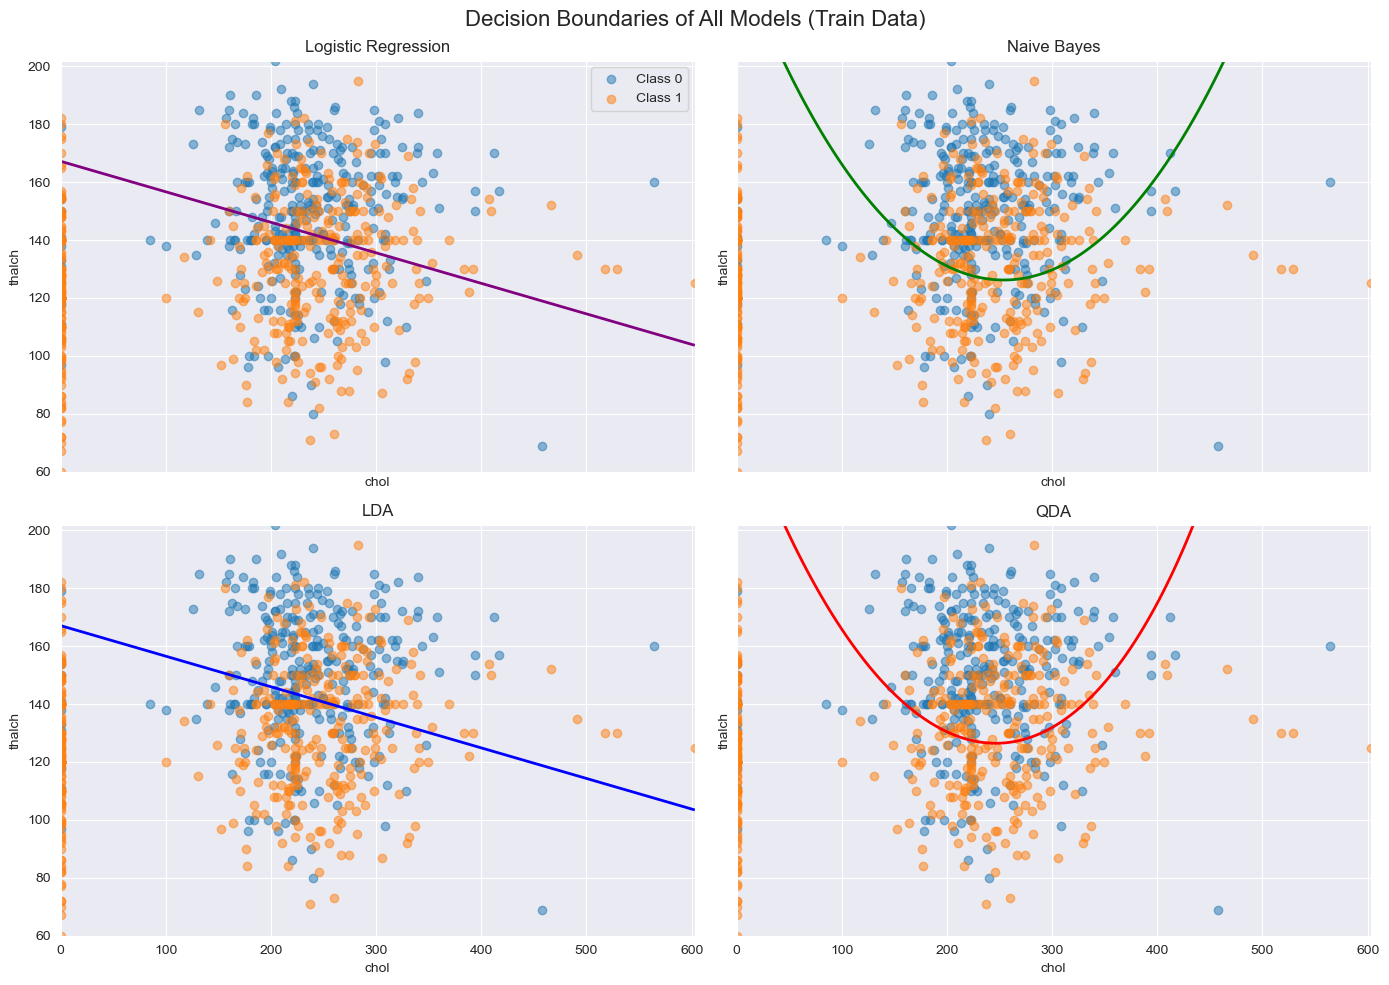

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

titles = [
    "Logistic Regression",
    "Naive Bayes",
    "LDA",
    "QDA"
]
colors = ['purple', 'green', 'blue', 'red']

# --- Logistic Regression ---
grid_aug = np.hstack([np.ones((grid.shape[0], 1)), grid])
log_probs = sigmoid(grid_aug @ logistic_weights).reshape(X.shape)
log_boundary = log_probs - 0.5

# --- Naive Bayes ---
nb_log_likelihood = {}
for cls in nb_params:
    mean = nb_params[cls]['mean']
    var = nb_params[cls]['var']
    prior = np.log(np.sum(y_train == cls) / len(y_train))

    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
    log_likelihood -= 0.5 * np.sum(((grid - mean) ** 2) / var, axis=1)

    nb_log_likelihood[cls] = log_likelihood + prior

nb_boundary = (nb_log_likelihood[1] - nb_log_likelihood[0]).reshape(X.shape)

# --- LDA ---
lda_score_grid = []
for cls in np.unique(y_train):
    mean = X_train[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    score = grid @ lda_inv_cov @ mean - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_score_grid.append(score)

lda_boundary = (lda_score_grid[1] - lda_score_grid[0]).reshape(X.shape)

# --- QDA ---
qda_score_grid = []
for cls in np.unique(y_train):
    Xc = X_train[y_train == cls]
    mean = Xc.mean(axis=0)
    cov = np.cov(Xc.T)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    prior = np.log(len(Xc) / len(X_train))

    diff = grid - mean
    score = -0.5 * np.sum(diff @ inv_cov * diff, axis=1) - 0.5 * np.log(det_cov) + prior
    qda_score_grid.append(score)

qda_boundary = (qda_score_grid[1] - qda_score_grid[0]).reshape(X.shape)

# Plotting each model
boundaries = [log_boundary, nb_boundary, lda_boundary, qda_boundary]

for ax, title, boundary, color in zip(axes.flat, titles, boundaries, colors):
    ax.contour(X, Y, boundary, levels=[0], colors=color, linewidths=2)
    for cls in np.unique(y_train):
        ax.scatter(
            X_train[y_train == cls][:, 0],
            X_train[y_train == cls][:, 1],
            label=f"Class {cls}" if ax == axes[0, 0] else "",
            alpha=0.5
        )
    ax.set_title(title)
    ax.set_xlabel(selected_features[0])
    ax.set_ylabel(selected_features[1])
    ax.grid(True)

axes[0, 0].legend()
plt.suptitle("Decision Boundaries of All Models (Train Data)", fontsize=16)
plt.tight_layout()
plt.show()


In [79]:
# Add Gaussian noise (mean 0, std 0.1×std of each feature)
X_train_noisy = X_train.copy()
stds = X_train.std(axis=0)
noise = np.random.normal(loc=0, scale=0.1 * stds, size=X_train.shape)
X_train_noisy += noise


In [80]:
# Add intercept
X_log = np.hstack([np.ones((X_train_noisy.shape[0], 1)), X_train_noisy])
y_log = y_train.reshape(-1, 1)
w_noisy = np.zeros((X_log.shape[1], 1))

# Newton’s method
for _ in range(20):
    z = X_log @ w_noisy
    p = 1 / (1 + np.exp(-z))
    grad = X_log.T @ (y_log - p)
    S = np.diag((p * (1 - p)).flatten())
    H = X_log.T @ S @ X_log
    w_noisy += np.linalg.inv(H) @ grad

# Predictions
X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
log_probs = 1 / (1 + np.exp(-X_test_aug @ w_noisy))
log_preds = (log_probs >= 0.5).astype(int).flatten()


In [81]:
# Naive Bayes on noisy data
nb_params_noisy = {}
for cls in np.unique(y_train):
    subset = X_train_noisy[y_train == cls]
    nb_params_noisy[cls] = {
        'mean': subset.mean(axis=0),
        'var': subset.var(axis=0)
    }

def naive_bayes_predict(X, model_params):
    log_posteriors = []
    for cls in model_params:
        mean = model_params[cls]['mean']
        var = model_params[cls]['var']
        prior = np.log(np.sum(y_train == cls) / len(y_train))
        log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
        log_likelihood -= 0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        log_posteriors.append(prior + log_likelihood)
    return np.argmax(np.vstack(log_posteriors), axis=0)

nb_preds = naive_bayes_predict(X_test, nb_params_noisy)


In [82]:
# LDA
lda_pooled_cov = sum(
    (np.sum(y_train == cls) / len(y_train)) * np.cov(X_train_noisy[y_train == cls].T)
    for cls in np.unique(y_train)
)
lda_inv_cov = np.linalg.inv(lda_pooled_cov)

lda_scores = []
for cls in np.unique(y_train):
    mean = X_train_noisy[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    score = X_test @ lda_inv_cov @ mean - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_scores.append(score)

lda_preds = np.argmax(np.vstack(lda_scores), axis=0)

# QDA
qda_scores = []
for cls in np.unique(y_train):
    Xc = X_train_noisy[y_train == cls]
    mean = Xc.mean(axis=0)
    cov = np.cov(Xc.T)
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    prior = np.log(len(Xc) / len(y_train))
    diff = X_test - mean
    score = -0.5 * np.sum(diff @ inv_cov * diff, axis=1) - 0.5 * np.log(det_cov) + prior
    qda_scores.append(score)

qda_preds = np.argmax(np.vstack(qda_scores), axis=0)


In [83]:
def evaluate(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    return accuracy, precision, recall, f1

# Compute metrics
log_metrics_noisy = evaluate(y_test, log_preds)
nb_metrics_noisy = evaluate(y_test, nb_preds)
lda_metrics_noisy = evaluate(y_test, lda_preds)
qda_metrics_noisy = evaluate(y_test, qda_preds)

# Print nicely
def print_metrics(name, metrics):
    acc, prec, rec, f1 = metrics
    print(f"{name:<22} | Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")

print("=== Evaluation After Adding Gaussian Noise ===")
print_metrics("Logistic Regression", log_metrics_noisy)
print_metrics("Naive Bayes", nb_metrics_noisy)
print_metrics("LDA", lda_metrics_noisy)
print_metrics("QDA", qda_metrics_noisy)


=== Evaluation After Adding Gaussian Noise ===
Logistic Regression    | Accuracy: 0.712 | Precision: 0.733 | Recall: 0.755 | F1-Score: 0.744
Naive Bayes            | Accuracy: 0.674 | Precision: 0.733 | Recall: 0.647 | F1-Score: 0.687
LDA                    | Accuracy: 0.712 | Precision: 0.738 | Recall: 0.745 | F1-Score: 0.741
QDA                    | Accuracy: 0.674 | Precision: 0.733 | Recall: 0.647 | F1-Score: 0.687


In [89]:
# === 1. Remove 'chol' and prepare reduced data ===
reduced_features = [f for f in selected_features if f != 'chol']

X_train_reduced = train_df[reduced_features].values
X_test_reduced = test_df[reduced_features].values
y_train = train_df[target_col].values
y_test = test_df[target_col].values


In [90]:
# === 2. Logistic Regression ===
X_log = np.hstack([np.ones((X_train_reduced.shape[0], 1)), X_train_reduced])
w_reduced = np.zeros((X_log.shape[1], 1))

for _ in range(20):
    z = X_log @ w_reduced
    p = 1 / (1 + np.exp(-z))
    grad = X_log.T @ (y_train.reshape(-1, 1) - p)
    S = np.diag((p * (1 - p)).flatten())
    H = X_log.T @ S @ X_log
    w_reduced += np.linalg.inv(H) @ grad

X_test_aug = np.hstack([np.ones((X_test_reduced.shape[0], 1)), X_test_reduced])
log_probs = 1 / (1 + np.exp(-X_test_aug @ w_reduced))
log_preds = (log_probs >= 0.5).astype(int).flatten()


In [91]:
# === 3. Naive Bayes ===
nb_params_reduced = {}
for cls in np.unique(y_train):
    subset = X_train_reduced[y_train == cls]
    nb_params_reduced[cls] = {
        'mean': subset.mean(axis=0),
        'var': subset.var(axis=0)
    }

def naive_bayes_predict(X, model_params):
    log_posteriors = []
    for cls in model_params:
        mean = model_params[cls]['mean']
        var = model_params[cls]['var']
        prior = np.log(np.sum(y_train == cls) / len(y_train))
        log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
        log_likelihood -= 0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        log_posteriors.append(prior + log_likelihood)
    return np.argmax(np.vstack(log_posteriors), axis=0)

nb_preds = naive_bayes_predict(X_test_reduced, nb_params_reduced)


In [92]:
# === 4. LDA ===
lda_pooled_cov = sum(
    (np.sum(y_train == cls) / len(y_train)) * np.cov(X_train_reduced[y_train == cls].T)
    for cls in np.unique(y_train)
)
lda_inv_cov = 1 / lda_pooled_cov if np.isscalar(lda_pooled_cov) else np.linalg.inv(lda_pooled_cov)

lda_scores = []
for cls in np.unique(y_train):
    mean = X_train_reduced[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    if np.isscalar(lda_inv_cov):
        score = (X_test_reduced * lda_inv_cov * mean).flatten() - 0.5 * mean * lda_inv_cov * mean + prior
    else:
        score = (X_test_reduced @ lda_inv_cov @ mean).flatten() - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_scores.append(score)

lda_preds = np.argmax(np.vstack(lda_scores), axis=0)


In [95]:
qda_scores = []

for cls in np.unique(y_train):
    Xc = X_train_reduced[y_train == cls]
    mean = Xc.mean(axis=0)

    # Get 2D shape-safe covariance
    cov_raw = np.cov(Xc.T)
    if cov_raw.ndim == 0:
        cov = np.array([[cov_raw]])
    elif cov_raw.ndim == 1:
        cov = np.array([[cov_raw.item()]])
    else:
        cov = cov_raw

    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    diff = X_test_reduced - mean
    if diff.ndim == 1:
        diff = diff[:, np.newaxis]

    mahal = np.sum(diff @ inv_cov * diff, axis=1)
    prior = np.log(len(Xc) / len(y_train))
    score = -0.5 * mahal - 0.5 * np.log(det_cov) + prior

    qda_scores.append(score)

qda_preds = np.argmax(np.vstack(qda_scores), axis=0)


In [96]:
log_metrics_drop = evaluate(y_test, log_preds)
nb_metrics_drop = evaluate(y_test, nb_preds)
lda_metrics_drop = evaluate(y_test, lda_preds)
qda_metrics_drop = evaluate(y_test, qda_preds)

print("=== Evaluation After Removing 'chol' Feature ===")
print_metrics("Logistic Regression", log_metrics_drop)
print_metrics("Naive Bayes", nb_metrics_drop)
print_metrics("LDA", lda_metrics_drop)
print_metrics("QDA", qda_metrics_drop)


=== Evaluation After Removing 'chol' Feature ===
Logistic Regression    | Accuracy: 0.717 | Precision: 0.708 | Recall: 0.833 | F1-Score: 0.766
Naive Bayes            | Accuracy: 0.707 | Precision: 0.707 | Recall: 0.804 | F1-Score: 0.752
LDA                    | Accuracy: 0.717 | Precision: 0.708 | Recall: 0.833 | F1-Score: 0.766
QDA                    | Accuracy: 0.707 | Precision: 0.707 | Recall: 0.804 | F1-Score: 0.752


In [98]:
# === 1. Add synthetic outliers (±3σ to age, chol) ===
outlier_features = [f for f in ['chol', 'age'] if f in selected_features]

X_train_outlier = train_df[selected_features].copy().values
X_test_outlier = test_df[selected_features].copy().values
y_train = train_df[target_col].values
y_test = test_df[target_col].values

for f in outlier_features:
    f_index = selected_features.index(f)
    f_mean = X_train_outlier[:, f_index].mean()
    f_std = X_train_outlier[:, f_index].std()
    X_train_outlier[:5, f_index] = f_mean + 3 * f_std
    X_train_outlier[-5:, f_index] = f_mean - 3 * f_std


In [99]:
# === 2. Logistic Regression ===
X_log = np.hstack([np.ones((X_train_outlier.shape[0], 1)), X_train_outlier])
w_outlier = np.zeros((X_log.shape[1], 1))

for _ in range(20):
    z = X_log @ w_outlier
    p = 1 / (1 + np.exp(-z))
    grad = X_log.T @ (y_train.reshape(-1, 1) - p)
    S = np.diag((p * (1 - p)).flatten())
    H = X_log.T @ S @ X_log
    w_outlier += np.linalg.inv(H) @ grad

X_test_aug = np.hstack([np.ones((X_test_outlier.shape[0], 1)), X_test_outlier])
log_probs = 1 / (1 + np.exp(-X_test_aug @ w_outlier))
log_preds = (log_probs >= 0.5).astype(int).flatten()


In [100]:
# === 3. Naive Bayes ===
nb_params_outlier = {}
for cls in np.unique(y_train):
    subset = X_train_outlier[y_train == cls]
    nb_params_outlier[cls] = {
        'mean': subset.mean(axis=0),
        'var': subset.var(axis=0)
    }

def naive_bayes_predict(X, model_params):
    log_posteriors = []
    for cls in model_params:
        mean = model_params[cls]['mean']
        var = model_params[cls]['var']
        prior = np.log(np.sum(y_train == cls) / len(y_train))
        log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
        log_likelihood -= 0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        log_posteriors.append(prior + log_likelihood)
    return np.argmax(np.vstack(log_posteriors), axis=0)

nb_preds = naive_bayes_predict(X_test_outlier, nb_params_outlier)


In [101]:
# === 4. LDA ===
lda_pooled_cov = sum(
    (np.sum(y_train == cls) / len(y_train)) * np.cov(X_train_outlier[y_train == cls].T)
    for cls in np.unique(y_train)
)
lda_inv_cov = 1 / lda_pooled_cov if np.isscalar(lda_pooled_cov) else np.linalg.inv(lda_pooled_cov)

lda_scores = []
for cls in np.unique(y_train):
    mean = X_train_outlier[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    if np.isscalar(lda_inv_cov):
        score = (X_test_outlier * lda_inv_cov * mean).flatten() - 0.5 * mean * lda_inv_cov * mean + prior
    else:
        score = (X_test_outlier @ lda_inv_cov @ mean).flatten() - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_scores.append(score)

lda_preds = np.argmax(np.vstack(lda_scores), axis=0)


In [102]:
# === 5. QDA ===
qda_scores = []
for cls in np.unique(y_train):
    Xc = X_train_outlier[y_train == cls]
    mean = Xc.mean(axis=0)
    cov_raw = np.cov(Xc.T)
    if cov_raw.ndim == 0:
        cov = np.array([[cov_raw]])
    elif cov_raw.ndim == 1:
        cov = np.array([[cov_raw.item()]])
    else:
        cov = cov_raw
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    diff = X_test_outlier - mean
    if diff.ndim == 1:
        diff = diff[:, np.newaxis]
    mahal = np.sum(diff @ inv_cov * diff, axis=1)
    prior = np.log(len(Xc) / len(y_train))
    score = -0.5 * mahal - 0.5 * np.log(det_cov) + prior
    qda_scores.append(score)

qda_preds = np.argmax(np.vstack(qda_scores), axis=0)


In [103]:
# === 6. Evaluate ===
def evaluate(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    return accuracy, precision, recall, f1

log_metrics_outlier = evaluate(y_test, log_preds)
nb_metrics_outlier = evaluate(y_test, nb_preds)
lda_metrics_outlier = evaluate(y_test, lda_preds)
qda_metrics_outlier = evaluate(y_test, qda_preds)


In [104]:
# === 7. Print Results ===
def print_metrics(name, metrics):
    acc, prec, rec, f1 = metrics
    print(f"{name:<22} | Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")

print("=== Evaluation After Adding Synthetic Outliers ===")
print_metrics("Logistic Regression", log_metrics_outlier)
print_metrics("Naive Bayes", nb_metrics_outlier)
print_metrics("LDA", lda_metrics_outlier)
print_metrics("QDA", qda_metrics_outlier)


=== Evaluation After Adding Synthetic Outliers ===
Logistic Regression    | Accuracy: 0.701 | Precision: 0.733 | Recall: 0.725 | F1-Score: 0.729
Naive Bayes            | Accuracy: 0.663 | Precision: 0.727 | Recall: 0.627 | F1-Score: 0.674
LDA                    | Accuracy: 0.701 | Precision: 0.733 | Recall: 0.725 | F1-Score: 0.729
QDA                    | Accuracy: 0.668 | Precision: 0.730 | Recall: 0.637 | F1-Score: 0.681


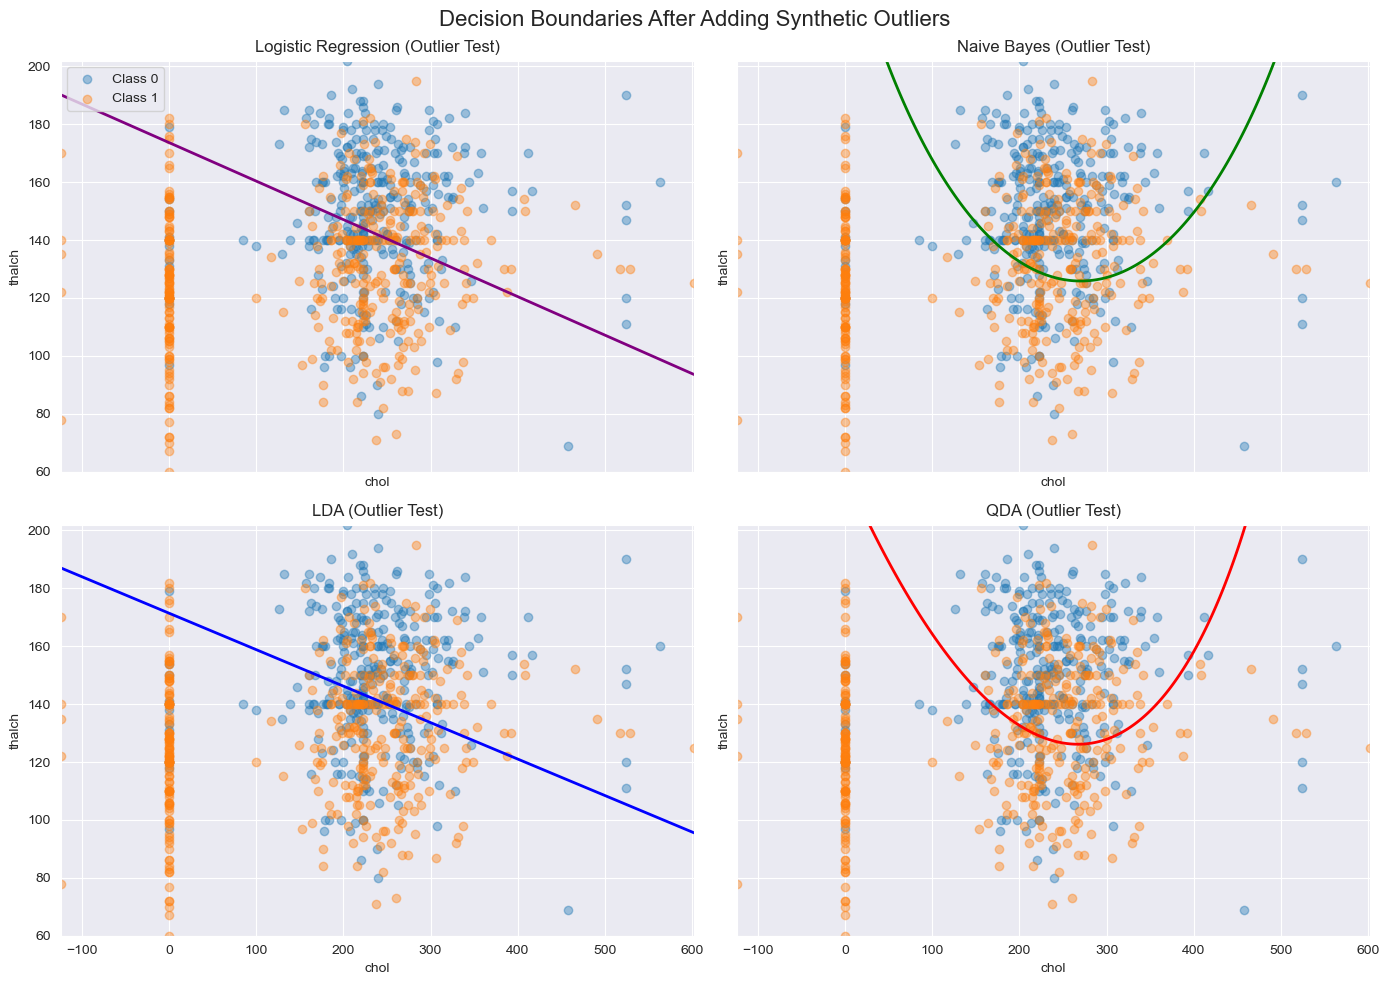

In [105]:
import matplotlib.pyplot as plt

# Prepare grid
x = np.linspace(X_train_outlier[:, 0].min(), X_train_outlier[:, 0].max(), 300)
y = np.linspace(X_train_outlier[:, 1].min(), X_train_outlier[:, 1].max(), 300)
X_grid, Y_grid = np.meshgrid(x, y)
grid = np.c_[X_grid.ravel(), Y_grid.ravel()]

# --- Logistic Regression ---
grid_aug = np.hstack([np.ones((grid.shape[0], 1)), grid])
log_probs_grid = 1 / (1 + np.exp(-grid_aug @ w_outlier))
log_boundary = log_probs_grid.reshape(X_grid.shape) - 0.5

# --- Naive Bayes ---
nb_scores = {}
for cls in nb_params_outlier:
    mean = nb_params_outlier[cls]['mean']
    var = nb_params_outlier[cls]['var']
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
    log_likelihood -= 0.5 * np.sum(((grid - mean) ** 2) / var, axis=1)
    nb_scores[cls] = log_likelihood + prior

nb_boundary = (nb_scores[1] - nb_scores[0]).reshape(X_grid.shape)

# --- LDA ---
lda_scores = []
for cls in np.unique(y_train):
    mean = X_train_outlier[y_train == cls].mean(axis=0)
    prior = np.log(np.sum(y_train == cls) / len(y_train))
    if np.isscalar(lda_inv_cov):
        score = (grid * lda_inv_cov * mean).flatten() - 0.5 * mean * lda_inv_cov * mean + prior
    else:
        score = (grid @ lda_inv_cov @ mean).flatten() - 0.5 * mean.T @ lda_inv_cov @ mean + prior
    lda_scores.append(score)

lda_boundary = (lda_scores[1] - lda_scores[0]).reshape(X_grid.shape)

# --- QDA ---
qda_scores = []
for cls in np.unique(y_train):
    Xc = X_train_outlier[y_train == cls]
    mean = Xc.mean(axis=0)
    cov_raw = np.cov(Xc.T)
    if cov_raw.ndim == 0:
        cov = np.array([[cov_raw]])
    elif cov_raw.ndim == 1:
        cov = np.array([[cov_raw.item()]])
    else:
        cov = cov_raw
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    diff = grid - mean
    if diff.ndim == 1:
        diff = diff[:, np.newaxis]
    mahal = np.sum(diff @ inv_cov * diff, axis=1)
    prior = np.log(len(Xc) / len(y_train))
    score = -0.5 * mahal - 0.5 * np.log(det_cov) + prior
    qda_scores.append(score)

qda_boundary = (qda_scores[1] - qda_scores[0]).reshape(X_grid.shape)

# === Plotting ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
titles = ["Logistic Regression", "Naive Bayes", "LDA", "QDA"]
boundaries = [log_boundary, nb_boundary, lda_boundary, qda_boundary]
colors = ['purple', 'green', 'blue', 'red']

for ax, title, boundary, color in zip(axes.flat, titles, boundaries, colors):
    ax.contour(X_grid, Y_grid, boundary, levels=[0], colors=color, linewidths=2)
    for cls in np.unique(y_train):
        ax.scatter(
            X_train_outlier[y_train == cls][:, 0],
            X_train_outlier[y_train == cls][:, 1],
            label=f"Class {cls}" if ax == axes[0, 0] else "",
            alpha=0.4
        )
    ax.set_title(f"{title} (Outlier Test)")
    ax.set_xlabel(selected_features[0])
    ax.set_ylabel(selected_features[1])
    ax.grid(True)

axes[0, 0].legend()
plt.suptitle("Decision Boundaries After Adding Synthetic Outliers", fontsize=16)
plt.tight_layout()
plt.show()
